<a href="https://colab.research.google.com/github/Tuan-LeHoang/hira_kata_recognition/blob/main/test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/2023_Project/OCR

/content/drive/MyDrive/2023_Project/OCR


In [2]:
!ls

best_model.pt		  hira_better_quality.zip      __pycache__
data			  logs			       Report
Data_Exploring.ipynb	  __MACOSX		       setup_google_colab.py
git_lfs_handwritten_hira  models		       test_model.ipynb
hira_better_quality	  Projector_TensorBoard.ipynb  Train.ipynb


In [3]:
!pip install japanize_matplotlib
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 30.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=f118d4680ace4e617ca332aef207f34ad746428631d05aeeb8b106561a48cd66
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00


#0. Import libs

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np # data processing
import matplotlib.pyplot as plt # Data visualization
import japanize_matplotlib
from tqdm import tqdm # Progress bar


In [5]:
import os
import pandas as pd
import torch.nn.functional as F

#1. Load data

##1.1. Load from raw data

In [6]:
list_characters_folders = "./git_lfs_handwritten_hira/hira_better_quality"


In [7]:
data = []
for folder in os.listdir(list_characters_folders):
    if folder == ".DS_Store":
        continue
    character_folder = os.path.join(list_characters_folders, folder)

    for character_image in os.listdir(character_folder):
        if character_image == ".DS_Store":
            continue
        character_image_path = os.path.join(character_folder, character_image)
        data.append([character_image_path, folder])

df = pd.DataFrame(data, columns=['file_name','label'])

In [8]:
sort_df = df.sort_values(by=["label"])


In [9]:
sort_df

,file_name,label
0,./git_lfs_handwritten_hira/hira_better_quality...,あ
29,./git_lfs_handwritten_hira/hira_better_quality...,あ
30,./git_lfs_handwritten_hira/hira_better_quality...,あ
31,./git_lfs_handwritten_hira/hira_better_quality...,あ
32,./git_lfs_handwritten_hira/hira_better_quality...,あ
...,...,...
2447,./git_lfs_handwritten_hira/hira_better_quality...,ん
2448,./git_lfs_handwritten_hira/hira_better_quality...,ん
2449,./git_lfs_handwritten_hira/hira_better_quality...,ん
2451,./git_lfs_handwritten_hira/hira_better_quality...,ん


In [10]:
labels = sort_df["label"].unique()
print(labels)

['あ' 'い' 'う' 'え' 'お' 'か' 'き' 'く' 'け' 'こ' 'さ' 'し' 'す' 'せ' 'そ' 'た' 'ち' 'つ'
 'て' 'と' 'な' 'に' 'ぬ' 'ね' 'の' 'は' 'ひ' 'ふ' 'へ' 'ほ' 'ま' 'み' 'む' 'め' 'も' 'や'
 'ゆ' 'よ' 'ら' 'り' 'る' 'れ' 'ろ' 'わ' 'を' 'ん']


##1.2. Split data

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [12]:
# Convert labels to numeric representation
def convert_to_one_hot_vector_labels(labels):
  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  # print("Numeric labels:", numeric_labels)

  # Convert numeric labels to one-hot vectors
  onehot_encoder = OneHotEncoder(sparse=False)
  onehot_labels = onehot_encoder.fit_transform(numeric_labels.reshape(-1, 1))

  return onehot_labels

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sort_df,
                                      test_size = 0.2,
                                      random_state = 42)

In [14]:
len(train_df)

1984

In [15]:
len(test_df)

496

###1.3. Dataset and Dataloader

In [16]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [17]:
cfg.root_dir = list_characters_folders
cfg.image_size = 224
cfg.batch_size = 32
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
class CustomDataset(Dataset):
    def __init__(self,
                 cfg,
                 df,
                 transform=None,
                  mode = None):
        self.root_dir = cfg.root_dir
        self.df = df
        self.file_names = df['file_name'].values
        self.labels = convert_to_one_hot_vector_labels(df['label'].values)

        if transform and mode != "val":
          self.transform = transform
        elif mode == "train":
          self.transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             A.Rotate(p=0.6, limit=[-20,20]),
                            #  A.HorizontalFlip(p = 0.6),
                             A.CoarseDropout(max_holes = 1, max_height = 32, max_width = 32, p = 0.3),
                             ToTensorV2()])
        elif mode == "val":
          self.transform = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             ToTensorV2()])


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = self.file_names[idx]
        # file_path = os.path.join(self.root_dir, self.file_names[idx])

        # Read an image with OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply augmentations
        augmented = self.transform(image=image)
        image = augmented['image']

        # Normalize because ToTensorV2() doesn't normalize the image
        image = image/255

        return image, label

In [19]:
train_dataset = CustomDataset(cfg, train_df, mode = "train")
valid_dataset = CustomDataset(cfg, test_df, mode = "val")

train_dataloader = DataLoader(train_dataset,
                          batch_size = cfg.batch_size,
                          shuffle = True)

valid_dataloader = DataLoader(valid_dataset,
                          batch_size = cfg.batch_size,
                          shuffle = False,
                              )

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#2. Model

In [20]:
import timm

cfg.n_classes = len(labels)
cfg.backbone = 'skresnet18'

model = timm.create_model(cfg.backbone,
                          pretrained = False,
                          num_classes = cfg.n_classes)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SelectiveKernelBasic(
      (conv1): SelectiveKernel(
        (paths): ModuleList(
          (0): ConvNormActAa(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (aa): Identity()
          )
          (1): ConvNormActAa(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, mom

In [22]:
model = model.to(cfg.device)


In [26]:
!ls

best_model.pt		  hira_better_quality.zip      __pycache__
data			  logs			       Report
Data_Exploring.ipynb	  __MACOSX		       setup_google_colab.py
git_lfs_handwritten_hira  models		       test_model.ipynb
hira_better_quality	  Projector_TensorBoard.ipynb  Train.ipynb


In [27]:
state_dict_pytorch = "./logs/Nhat_logs/skresnet18/best_model_Nhat_skresnet18.pt"

In [28]:
model.load_state_dict(torch.load(state_dict_pytorch))

<All keys matched successfully>

#3. Test function

In [23]:
from sklearn.metrics import accuracy_score

def calculate_accuracy_score(y, y_pred):
  metric = accuracy_score(y, y_pred)
  return metric

In [38]:
def calculate_metric(dataloader, model, cfg):
    # Validation mode
    model.eval()

    final_y = []
    final_y_pred = []

    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()

            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)

    # Calculate statistics
    final_y_pred = np.argmax(final_y_pred, axis=1)
    final_y_argmax = np.argmax(final_y, axis = 1)
    metric = calculate_accuracy_score(final_y_argmax, final_y_pred)

    return metric, final_y_pred, final_y_argmax

In [39]:
metric, y_pred, original_labels = calculate_metric(valid_dataloader, model, cfg)

100%|██████████| 16/16 [00:02<00:00,  7.80it/s]


In [40]:
metric

0.9959677419354839

In [41]:
y_pred

array([14,  4, 19, 32,  1, 16,  8, 25, 20, 30, 41,  7,  2, 25, 25, 45, 33,
       34,  9, 19,  8, 27, 36, 38, 24, 24, 26, 36, 37, 35, 24,  7, 25,  0,
       25,  1, 22,  4,  8, 45, 26, 42, 45, 35, 12, 20, 20,  2, 20, 23, 32,
       10, 15, 39, 16, 30,  8, 27, 21, 33, 33,  9, 27,  3, 32,  8, 31,  3,
       37, 42, 34, 33, 34, 14, 12, 16, 42, 41, 38,  3, 16, 31, 43, 17,  0,
       32, 38,  7, 36, 28, 42, 25, 37, 14, 23, 11, 16, 14, 17,  4, 26,  4,
       37, 36, 12, 12, 20, 36, 10, 12, 25, 45, 28, 19, 45,  5, 17, 24,  7,
       31, 42, 35, 24, 19, 30,  8, 18, 14, 28, 41, 13, 34, 36,  1,  3, 33,
       27, 34, 26, 40, 33, 30, 45, 41, 30, 34,  3, 11, 30, 40, 42, 25, 10,
        3, 15,  6, 15,  6, 17, 18, 28, 23, 22, 19, 18, 29, 44, 31,  8,  8,
       43, 44, 19,  4,  3, 20,  5, 24, 28, 28, 35, 17, 26, 25, 42, 19, 38,
       21, 19, 23, 25, 24, 36,  4, 19,  5, 12, 34, 11,  8, 12, 37, 25, 35,
       28, 32, 25, 37, 34, 26, 38,  5, 11,  1,  6, 30, 30,  3,  4, 42, 28,
       19, 36, 20, 36,  4

#3. Display report

##3.1. Confusion Matrix Display

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
cf_matrix = confusion_matrix(original_labels, y_pred)
print(cf_matrix)

[[ 7  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  8 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0 13]]


<Axes: >

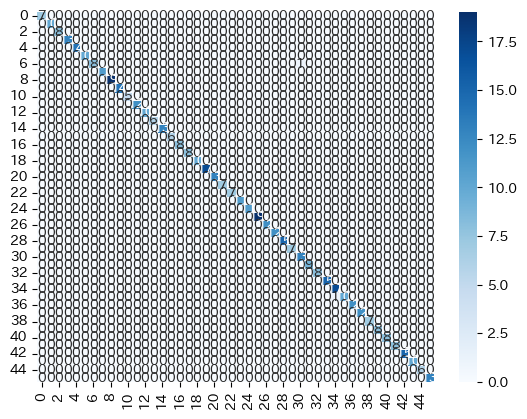

In [44]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

<Axes: >

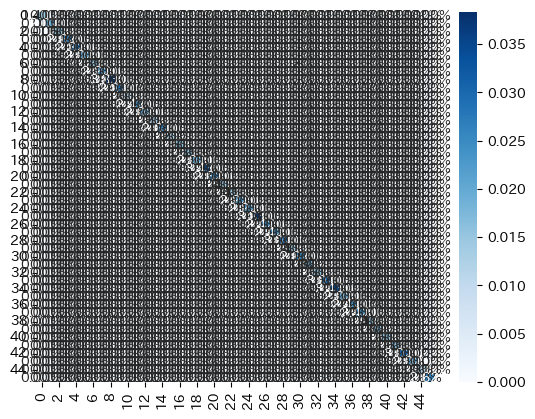

In [45]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

In [103]:
np.sum(cf_matrix)

496

In [106]:
# Calculate the sum of counts for each class
class_counts = np.sum(cf_matrix, axis=1)

# Calculate the percentage for each class
class_percentages = (cf_matrix / class_counts[:, np.newaxis]) * 100

# Round the percentages to two decimal places
class_percentages = np.round(class_percentages, 2)

# Print the result
print(class_percentages)

[[100.   0.   0. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 [  0.   0. 100. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 100.   0.   0.]
 [  0.   0.   0. ...   0. 100.   0.]
 [  0.   0.   0. ...   0.   0. 100.]]


In [109]:
len(class_percentages.flatten())

2116

In [110]:
detail_results_df = pd.DataFrame({'Class': labels, 'Percentage': np.diag(class_percentages)})

# Export the DataFrame to an Excel file
# detail_results_df.to_excel('class_percentages.xlsx', index=False)

In [111]:
detail_results_df

,Class,Percentage
0,あ,100.00
1,い,100.00
2,う,100.00
3,え,100.00
4,お,100.00
5,か,100.00
6,き,88.89
7,く,100.00
8,け,100.00
9,こ,100.00


In [112]:
percentage_save_results = "./logs/Nhat_logs/skresnet18/percentage_results.xlsx"

In [113]:
detail_results_df.to_excel(percentage_save_results)

##3.2. Export to exel file

In [46]:
test_df

,file_name,label
796,./git_lfs_handwritten_hira/hira_better_quality...,そ
228,./git_lfs_handwritten_hira/hira_better_quality...,お
1039,./git_lfs_handwritten_hira/hira_better_quality...,と
1741,./git_lfs_handwritten_hira/hira_better_quality...,む
91,./git_lfs_handwritten_hira/hira_better_quality...,い
...,...,...
2413,./git_lfs_handwritten_hira/hira_better_quality...,を
1119,./git_lfs_handwritten_hira/hira_better_quality...,な
178,./git_lfs_handwritten_hira/hira_better_quality...,え
1789,./git_lfs_handwritten_hira/hira_better_quality...,め


In [51]:
character_label_iterator = map(lambda item: labels[item], y_pred)

In [52]:
character_labels = list(character_label_iterator)

In [53]:
character_labels

['そ',
 'お',
 'と',
 'む',
 'い',
 'ち',
 'け',
 'は',
 'な',
 'ま',
 'れ',
 'く',
 'う',
 'は',
 'は',
 'ん',
 'め',
 'も',
 'こ',
 'と',
 'け',
 'ふ',
 'ゆ',
 'ら',
 'の',
 'の',
 'ひ',
 'ゆ',
 'よ',
 'や',
 'の',
 'く',
 'は',
 'あ',
 'は',
 'い',
 'ぬ',
 'お',
 'け',
 'ん',
 'ひ',
 'ろ',
 'ん',
 'や',
 'す',
 'な',
 'な',
 'う',
 'な',
 'ね',
 'む',
 'さ',
 'た',
 'り',
 'ち',
 'ま',
 'け',
 'ふ',
 'に',
 'め',
 'め',
 'こ',
 'ふ',
 'え',
 'む',
 'け',
 'み',
 'え',
 'よ',
 'ろ',
 'も',
 'め',
 'も',
 'そ',
 'す',
 'ち',
 'ろ',
 'れ',
 'ら',
 'え',
 'ち',
 'み',
 'わ',
 'つ',
 'あ',
 'む',
 'ら',
 'く',
 'ゆ',
 'へ',
 'ろ',
 'は',
 'よ',
 'そ',
 'ね',
 'し',
 'ち',
 'そ',
 'つ',
 'お',
 'ひ',
 'お',
 'よ',
 'ゆ',
 'す',
 'す',
 'な',
 'ゆ',
 'さ',
 'す',
 'は',
 'ん',
 'へ',
 'と',
 'ん',
 'か',
 'つ',
 'の',
 'く',
 'み',
 'ろ',
 'や',
 'の',
 'と',
 'ま',
 'け',
 'て',
 'そ',
 'へ',
 'れ',
 'せ',
 'も',
 'ゆ',
 'い',
 'え',
 'め',
 'ふ',
 'も',
 'ひ',
 'る',
 'め',
 'ま',
 'ん',
 'れ',
 'ま',
 'も',
 'え',
 'し',
 'ま',
 'る',
 'ろ',
 'は',
 'さ',
 'え',
 'た',
 'き',
 'た',
 'き',
 'つ',
 'て',
 'へ',
 'ね',
 'ぬ',
 'と',
 'て',
 'ほ',
 'を'

In [58]:
test_df["predicted_labels"] = character_labels

In [59]:
test_df.head(10)

,file_name,label,predict_labels,predicted_labels
796,./git_lfs_handwritten_hira/hira_better_quality...,そ,そ,そ
228,./git_lfs_handwritten_hira/hira_better_quality...,お,お,お
1039,./git_lfs_handwritten_hira/hira_better_quality...,と,と,と
1741,./git_lfs_handwritten_hira/hira_better_quality...,む,む,む
91,./git_lfs_handwritten_hira/hira_better_quality...,い,い,い
874,./git_lfs_handwritten_hira/hira_better_quality...,ち,ち,ち
472,./git_lfs_handwritten_hira/hira_better_quality...,け,け,け
1377,./git_lfs_handwritten_hira/hira_better_quality...,は,は,は
1098,./git_lfs_handwritten_hira/hira_better_quality...,な,な,な
1638,./git_lfs_handwritten_hira/hira_better_quality...,ま,ま,ま


In [60]:
test_df['Correct'] = test_df['label'] == test_df['predicted_labels']

In [61]:
test_df = test_df.drop("predict_labels", axis = 1)

In [62]:
test_df

,file_name,label,predicted_labels,Correct
796,./git_lfs_handwritten_hira/hira_better_quality...,そ,そ,True
228,./git_lfs_handwritten_hira/hira_better_quality...,お,お,True
1039,./git_lfs_handwritten_hira/hira_better_quality...,と,と,True
1741,./git_lfs_handwritten_hira/hira_better_quality...,む,む,True
91,./git_lfs_handwritten_hira/hira_better_quality...,い,い,True
...,...,...,...,...
2413,./git_lfs_handwritten_hira/hira_better_quality...,を,を,True
1119,./git_lfs_handwritten_hira/hira_better_quality...,な,な,True
178,./git_lfs_handwritten_hira/hira_better_quality...,え,え,True
1789,./git_lfs_handwritten_hira/hira_better_quality...,め,め,True


In [64]:
test_df["Correct"].sum()

494

In [65]:
494/496

0.9959677419354839

In [66]:
sorted_test_df = test_df.sort_values(by=["label"])

In [67]:
sorted_test_df

,file_name,label,predicted_labels,Correct
24,./git_lfs_handwritten_hira/hira_better_quality...,あ,あ,True
15,./git_lfs_handwritten_hira/hira_better_quality...,あ,あ,True
20,./git_lfs_handwritten_hira/hira_better_quality...,あ,あ,True
13,./git_lfs_handwritten_hira/hira_better_quality...,あ,あ,True
17,./git_lfs_handwritten_hira/hira_better_quality...,あ,あ,True
...,...,...,...,...
2475,./git_lfs_handwritten_hira/hira_better_quality...,ん,ん,True
2435,./git_lfs_handwritten_hira/hira_better_quality...,ん,ん,True
2434,./git_lfs_handwritten_hira/hira_better_quality...,ん,ん,True
2432,./git_lfs_handwritten_hira/hira_better_quality...,ん,ん,True


In [70]:
save_debug_results = "./logs/Nhat_logs/skresnet18/debug.xlsx"
sorted_test_df.to_excel(save_debug_results)

##3.3. Explore which cases model produces wrong results

In [71]:
false_cases_df = sorted_test_df[sorted_test_df["Correct"] == False]

In [72]:
false_cases_df

,file_name,label,predicted_labels,Correct
347,./git_lfs_handwritten_hira/hira_better_quality...,き,ま,False
1907,./git_lfs_handwritten_hira/hira_better_quality...,や,も,False


In [90]:
false_cases_df1 = false_cases_df.head(1)

In [91]:
false_cases_df1

,file_name,label,predicted_labels,Correct
347,./git_lfs_handwritten_hira/hira_better_quality...,き,ま,False


In [73]:
from PIL import Image

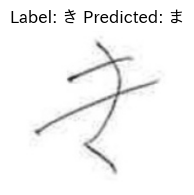

In [102]:
num_rows = len(false_cases_df1)
num_cols = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(2, 2))

# Iterate over the rows of the DataFrame
i = 0
for index, row in false_cases_df1.iterrows():
    # Get the image path, label, and predicted label
    image_path = row['file_name']
    label = row['label']
    predicted_label = row['predicted_labels']

    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Label: {label} Predicted: {predicted_label}')
    plt.axis('off')
    # axs[i].imshow(image)
    # axs[i].set_title(f'Label: {label} Predicted: {predicted_label}')
    # axs[i].axis('off')

    # axs[i].set_xticks([])
    # axs[i].set_yticks([])
    # i+= 1
    # break

# Adjust the spacing between subplots
# plt.tight_layout()
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.5)

plt.savefig("./logs/Nhat_logs/skresnet18/wrong_cases.png")
# Show the plot
plt.show()
